In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2

from feature_utils import (get_gray_hist, rgb_stats,
                              vessels_area, disc_area,
                              hsv_stats, rgb_equalize_hist_stats)

%load_ext autoreload
%autoreload 2

# Eye-eye P: Ocular Disease Classification

![Title](resources/title.gif)

# Executive Summary

TODO: Exec summary.

# Introduction

TODO: Introduction

# Problem Statement

TODO: Problem Statement

# Significance of the Study

TODO: Significance of the Study

# Dataset

## Background

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

## Download the Dataset

In [3]:
# Run in terminal
# kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

In [5]:
# Unzip the file
# !unzip ocular-disease-recognition-odir5k.zip

TODO: Explain the folder structure of the dataset.

## Data Description

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

    Normal (N),
    Diabetes (D),
    Glaucoma (G),
    Cataract (C),
    Age related Macular Degeneration (A),
    Hypertension (H),
    Pathological Myopia (M),
    Other diseases/abnormalities (O)
    
Reference: https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k
TODO: Explain that we only used Normal, Cataract and Pathological Myopia. 

# Methodology

# Results and Discussion

# Conclusion and Recommendation

# References

# Feature Generation

## Imports

## Loading the DataFrame

In [2]:
df = pd.read_csv("full_df.csv")
# Important Features
features = ['ID', 'Patient Age', 'Patient Sex', 
            'labels', 'filename']
df = df[features]
df['labels'] = df['labels'].str[2:3]
df['filepath'] = 'preprocessed_images/' + df['filename']
df = df[df['labels'] != 'O'].copy()
df = df.reset_index(drop=True)
df.head()

,ID,Patient Age,Patient Sex,labels,filename,filepath
0,0,69,Female,N,0_right.jpg,preprocessed_images/0_right.jpg
1,1,57,Male,N,1_right.jpg,preprocessed_images/1_right.jpg
2,2,42,Male,D,2_right.jpg,preprocessed_images/2_right.jpg
3,4,53,Male,D,4_right.jpg,preprocessed_images/4_right.jpg
4,5,50,Female,D,5_right.jpg,preprocessed_images/5_right.jpg


## Feature 1: Bright Spots
Get the number of bright spots in the image and the total area of these bright spots

In [4]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import threshold_otsu

<BarContainer object of 50 artists>

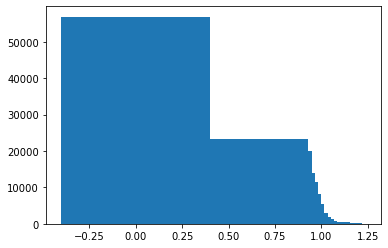

In [5]:
idx = 24
image = imread(df.iloc[idx]['filepath'])
image = rgb2gray(image)
image_flat = image.flatten()
# image_flat = image_flat[image_flat > 0.01]
count, bins = np.histogram(image_flat, bins=50)
bins = bins[:-1]
plt.bar(bins, count)

<BarContainer object of 50 artists>

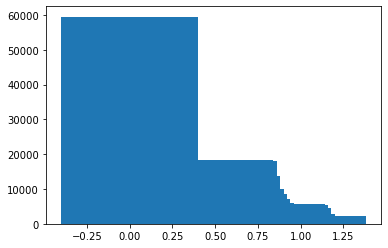

In [6]:
idx = 6
image = imread(df.iloc[idx]['filepath'])
image = rgb2gray(image)
image_flat = image.flatten()
# image_flat = image_flat[image_flat > 0.01]
count, bins = np.histogram(image_flat, bins=50)
bins = bins[:-1]
plt.bar(bins, count)

In [11]:
res_df = hsv_stats(res_df)

100%|██████████| 5684/5684 [08:43<00:00, 10.85it/s]


In [12]:
res_df = rgb_stats(res_df)

100%|██████████| 5684/5684 [01:37<00:00, 58.00it/s]


In [13]:
res_df = rgb_equalize_hist_stats(res_df)

In [221]:
res_df = get_gray_hist(res_df)
res_df = vessels_area(res_df)

In [224]:
res_df = disc_area(res_df)

100%|██████████| 5684/5684 [01:43<00:00, 54.92it/s]


In [240]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

new_res_df = pd.read_csv('results.csv.gz')
new_res_df = new_res_df[new_res_df['labels'].isin(['N', 'C', 'G'])]
print(new_res_df.shape)

X = new_res_df.drop(columns=['ID', 'labels', 'filename', 'filepath'])
X['Patient Sex'] = X['Patient Sex'].map({'Male': 1, 'Female': 0})
y = new_res_df['labels']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y)

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

print(classification_report(clf.predict(X_train), y_train))

print(classification_report(clf.predict(X_test), y_test))

np.mean(clf.predict(X_test) == y_test)

(3450, 86)
              precision    recall  f1-score   support

           C       0.88      1.00      0.93       205
           G       0.49      1.00      0.66       112
           N       1.00      0.94      0.97      2443

    accuracy                           0.95      2760
   macro avg       0.79      0.98      0.85      2760
weighted avg       0.97      0.95      0.95      2760

              precision    recall  f1-score   support

           C       0.73      0.88      0.80        49
           G       0.04      1.00      0.07         2
           N       0.99      0.89      0.94       639

    accuracy                           0.89       690
   macro avg       0.58      0.92      0.60       690
weighted avg       0.97      0.89      0.92       690



0.8884057971014493

<AxesSubplot:>

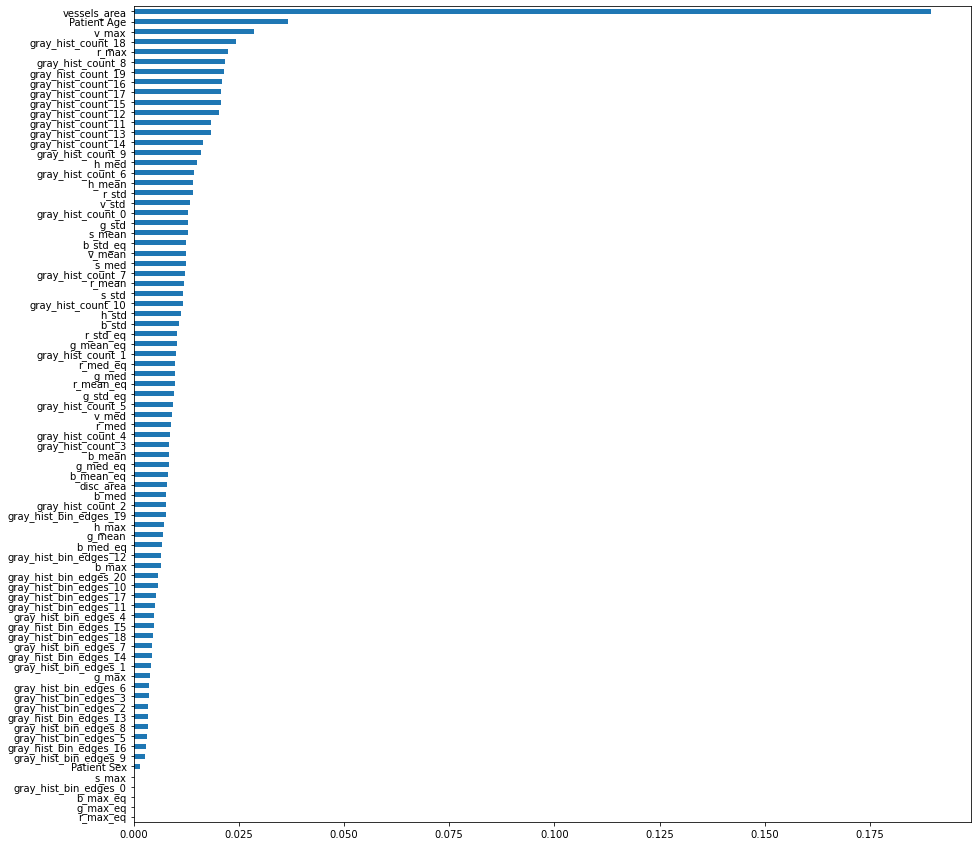

In [232]:
y_feat = clf.feature_importances_
x_feat = X.columns
pd.Series(y_feat, index=x_feat).sort_values().plot.barh(figsize=(15, 15))

In [214]:
from skimage.morphology import dilation, erosion

def visualize_discs(df, image_index):
    """Visualize an image after applying Canny Edge Detection
    """
    
    image = imread(df.loc[image_index,'filepath'])
    image = cv2.resize(image, (224,224))
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                              norm_type = cv2.NORM_MINMAX, 
                              dtype =cv2.CV_8U)
    img_can = cv2.Canny(image, 150, 165)
    
    img_can = dilation(erosion(erosion(dilation(dilation(dilation(img_can))))))
    
    img_can = img_can[35:189,35:189]
    
    cnts = cv2.findContours(img_can, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(img_can,[c], 0, (255,), -1)
    
    for i in range(10):
        img_can = erosion(img_can)
    
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax = ax.flatten()
    
#     ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
#     ax[1].axis('off')
    ax[1].set_title(f'Detected Blood Vessels, area={img_can.sum()}')
    ax[1].imshow(img_can, cmap='gray')
    
    plt.show()

In [215]:
df.query("labels == 'G'")

,ID,Patient Age,Patient Sex,labels,filename,filepath,h_mean,s_mean,v_mean,h_med,...,b_mean_eq,r_med_eq,g_med_eq,b_med_eq,r_std_eq,g_std_eq,b_std_eq,r_max_eq,g_max_eq,b_max_eq
96,167,71,Male,G,167_right.jpg,preprocessed_images/167_right.jpg,0.058725,0.418236,0.459664,0.050546,...,0.525698,0.501455,0.515147,0.503567,0.261720,0.260963,0.262461,1.0,1.0,1.0
336,583,54,Male,G,583_right.jpg,preprocessed_images/583_right.jpg,0.075298,0.391164,0.392090,0.041667,...,0.526617,0.504664,0.514210,0.524554,0.262166,0.260919,0.262342,1.0,1.0,1.0
434,746,59,Male,G,746_right.jpg,preprocessed_images/746_right.jpg,0.066742,0.457360,0.571321,0.060078,...,0.526167,0.506477,0.514868,0.502790,0.263370,0.260923,0.262746,1.0,1.0,1.0
533,931,65,Male,G,931_right.jpg,preprocessed_images/931_right.jpg,0.072868,0.700539,0.615774,0.060700,...,0.530563,0.502810,0.521365,0.500319,0.263760,0.262131,0.265524,1.0,1.0,1.0
657,1209,69,Female,G,1209_right.jpg,preprocessed_images/1209_right.jpg,0.068688,0.755713,0.201163,0.053191,...,0.580159,0.501674,0.500897,0.586396,0.261899,0.254360,0.230494,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,1986,70,Male,G,1986_left.jpg,preprocessed_images/1986_left.jpg,0.071039,0.506607,0.264439,0.052381,...,0.523248,0.501774,0.511280,0.517080,0.279956,0.280724,0.281368,1.0,1.0,1.0
3841,2030,66,Male,G,2030_left.jpg,preprocessed_images/2030_left.jpg,0.072115,0.399849,0.443092,0.060976,...,0.523967,0.503109,0.506138,0.503906,0.261283,0.260953,0.263386,1.0,1.0,1.0
3844,2041,55,Female,G,2041_left.jpg,preprocessed_images/2041_left.jpg,0.072311,0.618089,0.567788,0.064762,...,0.523183,0.501674,0.500917,0.510483,0.263855,0.263013,0.264780,1.0,1.0,1.0
3848,2063,77,Male,G,2063_left.jpg,preprocessed_images/2063_left.jpg,0.079886,0.359505,0.235828,0.061728,...,0.520303,0.514668,0.512815,0.529157,0.278196,0.275703,0.275109,1.0,1.0,1.0


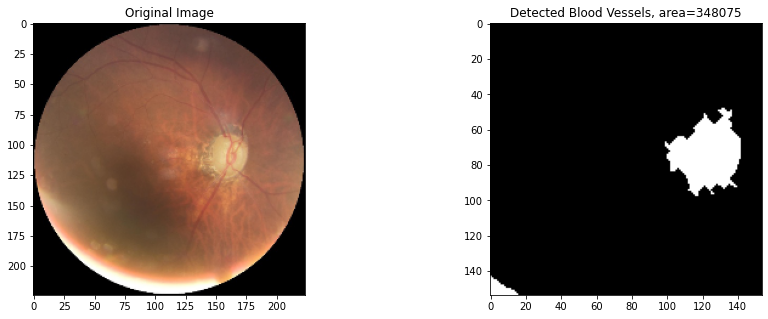

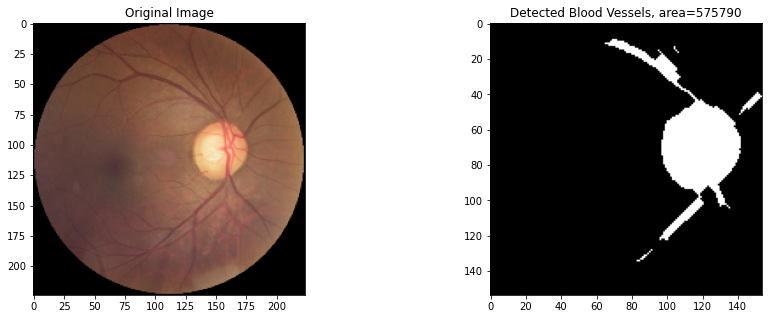

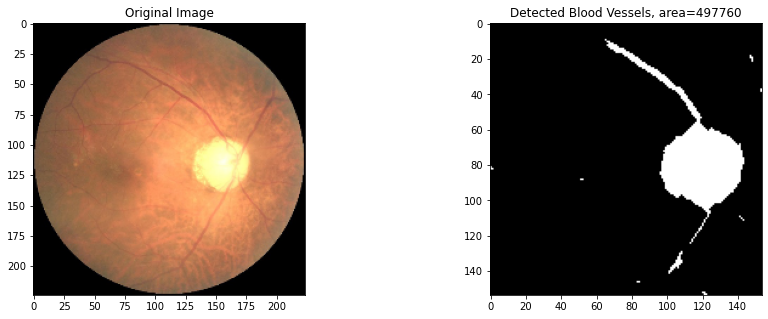

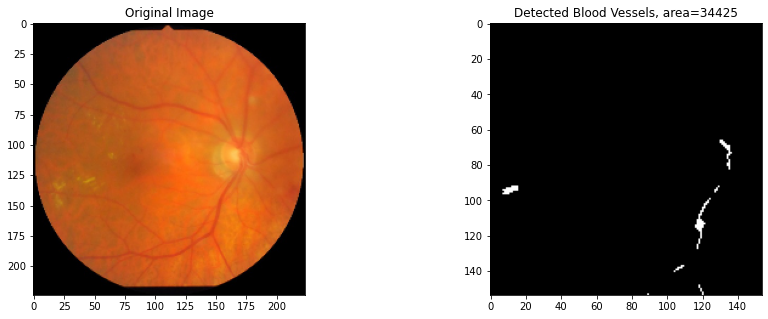

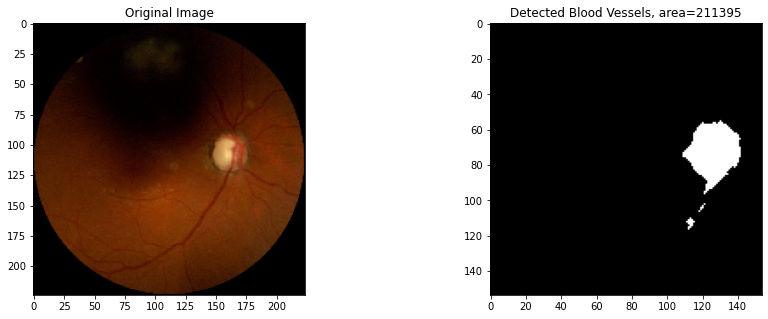

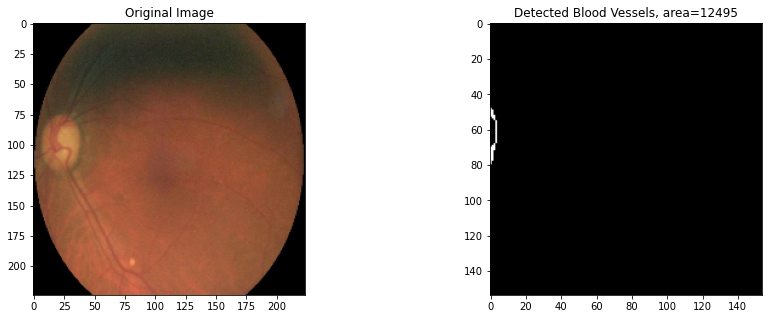

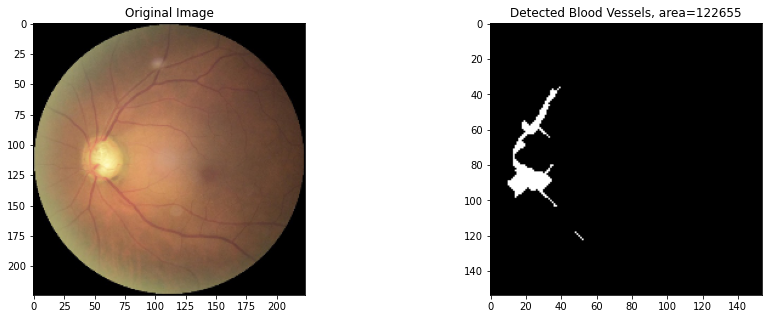

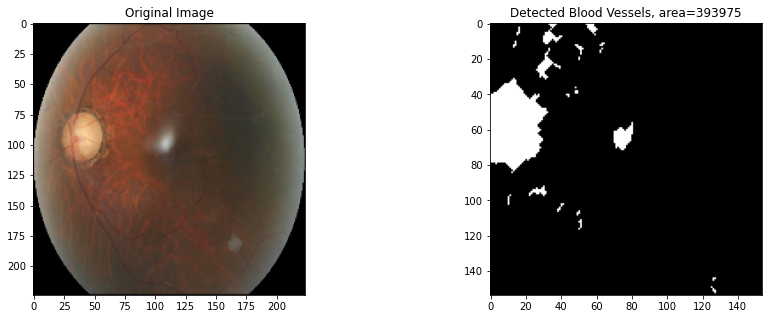

In [216]:
for i in [96, 336, 434, 533, 657, 3834, 3841, 3848]:
    visualize_vessels(df, i)

In [217]:
df.query("labels == 'N'")

,ID,Patient Age,Patient Sex,labels,filename,filepath,h_mean,s_mean,v_mean,h_med,...,b_mean_eq,r_med_eq,g_med_eq,b_med_eq,r_std_eq,g_std_eq,b_std_eq,r_max_eq,g_max_eq,b_max_eq
0,0,69,Female,N,0_right.jpg,preprocessed_images/0_right.jpg,0.087681,0.511488,0.246896,0.076923,...,0.541652,0.501694,0.500259,0.587532,0.263335,0.263216,0.265299,1.0,1.0,1.0
1,1,57,Male,N,1_right.jpg,preprocessed_images/1_right.jpg,0.075541,0.483012,0.510955,0.074074,...,0.524914,0.508111,0.510403,0.506716,0.263960,0.262255,0.264818,1.0,1.0,1.0
7,8,59,Male,N,8_right.jpg,preprocessed_images/8_right.jpg,0.050498,0.636729,0.503050,0.040918,...,0.523936,0.502671,0.515406,0.522122,0.265109,0.263932,0.264021,1.0,1.0,1.0
8,10,70,Male,N,10_right.jpg,preprocessed_images/10_right.jpg,0.059141,0.532171,0.590377,0.051440,...,0.514368,0.509706,0.513512,0.514629,0.276608,0.275031,0.275713,1.0,1.0,1.0
18,29,59,Male,N,29_right.jpg,preprocessed_images/29_right.jpg,0.078739,0.413352,0.298594,0.069892,...,0.526987,0.507175,0.502850,0.520727,0.261581,0.260844,0.262892,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,4637,45,Male,N,4637_left.jpg,preprocessed_images/4637_left.jpg,0.071088,0.519274,0.445380,0.066265,...,0.527671,0.510005,0.507354,0.509347,0.262484,0.261207,0.263480,1.0,1.0,1.0
5650,4639,60,Female,N,4639_left.jpg,preprocessed_images/4639_left.jpg,0.101601,0.790166,0.581470,0.102310,...,0.549200,0.509247,0.511559,0.506836,0.261994,0.262111,0.258460,1.0,1.0,1.0
5652,4641,56,Male,N,4641_left.jpg,preprocessed_images/4641_left.jpg,0.073864,0.441165,0.549782,0.070175,...,0.525482,0.504265,0.504504,0.515027,0.262132,0.260853,0.262893,1.0,1.0,1.0
5670,4672,65,Male,N,4672_left.jpg,preprocessed_images/4672_left.jpg,0.071603,0.419432,0.579048,0.069821,...,0.527170,0.505580,0.518495,0.500658,0.262208,0.260385,0.262085,1.0,1.0,1.0


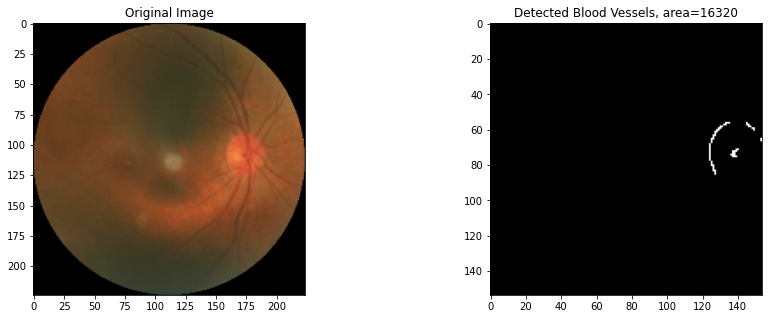

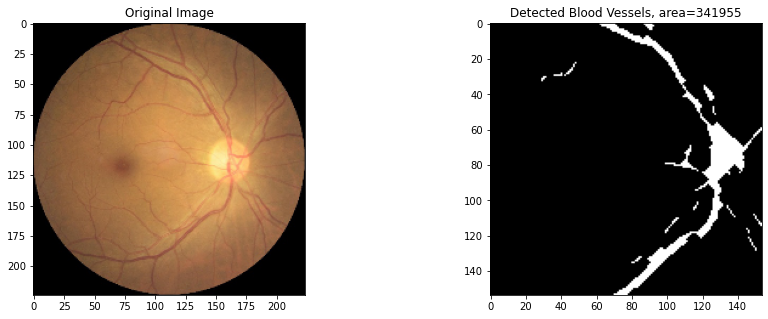

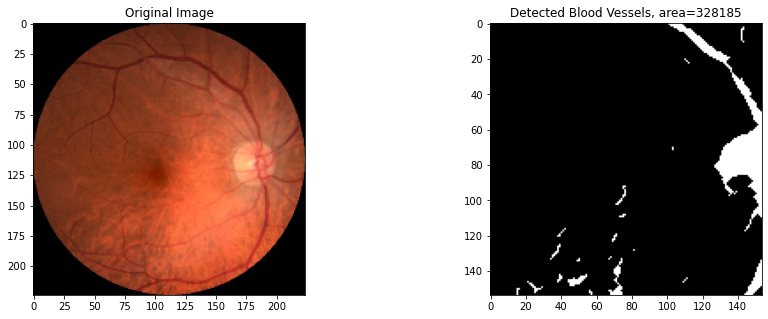

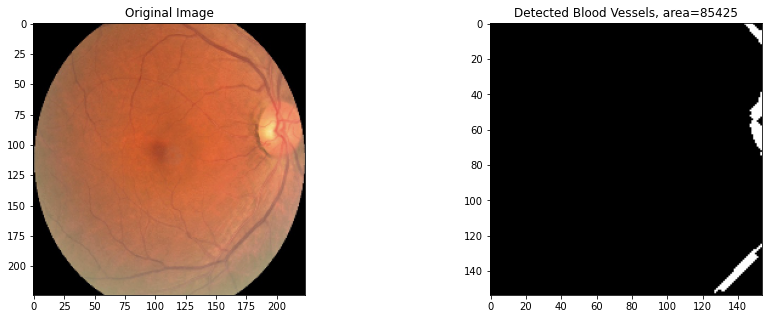

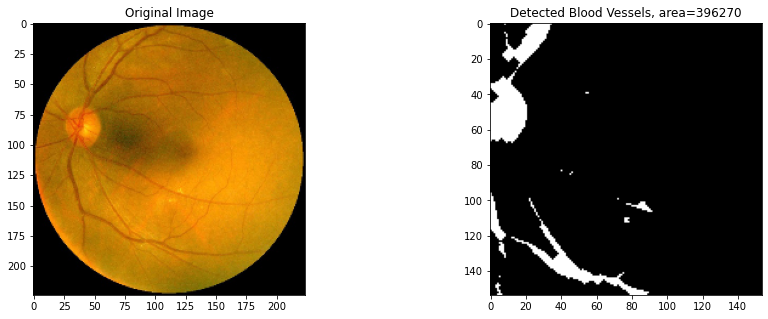

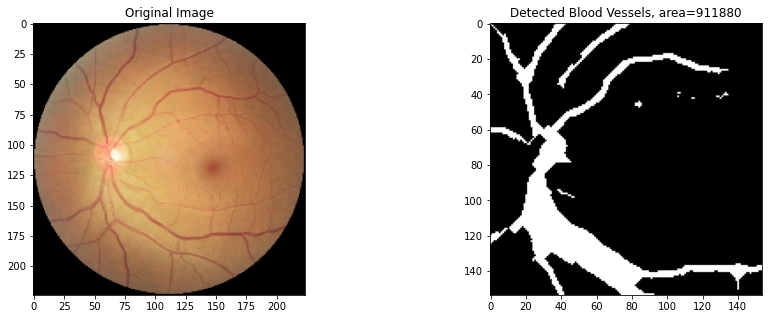

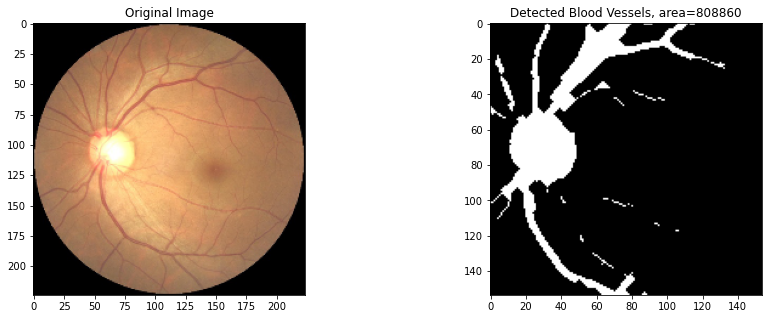

In [218]:
for i in [0, 1, 7, 8, 5650, 5652, 5670]:
    visualize_vessels(df, i)

In [268]:
from skimage.morphology import dilation, erosion

def visualize_discs_path(path):
    """Visualize an image after applying Canny Edge Detection
    """
    
    image = imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                              norm_type = cv2.NORM_MINMAX, 
                              dtype =cv2.CV_8U)
    img_can = cv2.Canny(image, 135, 150)
    
    img_can = dilation(erosion(erosion(dilation(dilation(dilation(img_can))))))
    
    img_can = img_can[35:189,35:189]
    
    cnts = cv2.findContours(img_can, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(img_can,[c], 0, (255,), -1)
    
    for i in range(10):
        img_can = erosion(img_can)
    
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax = ax.flatten()
    
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    ax[1].axis('off')
    ax[1].set_title(f'Detected Optic, area={img_can.sum()}')
    ax[1].imshow(img_can, cmap='gray')
    
    plt.show()

In [269]:
import os

myopia_16_right.jpg


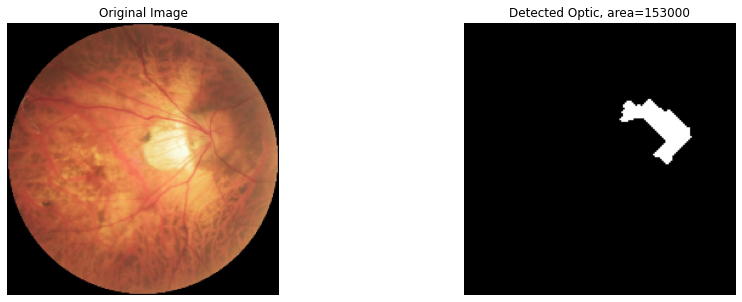

normal_236_right.jpg


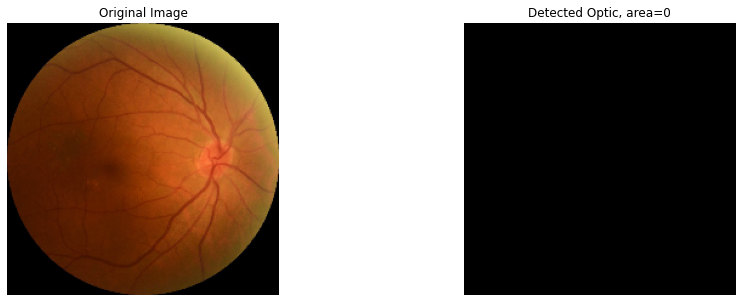

cataract_112_right.jpg


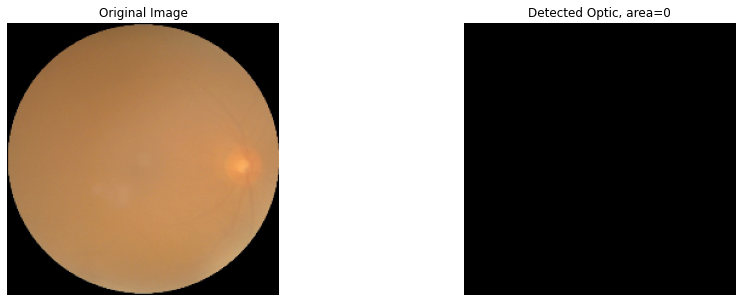

In [270]:
for file in os.listdir('subset'):
    print(file)
    visualize_discs_path('subset/'+file)

In [271]:
from skimage.morphology import dilation, erosion

def visualize_vessels_path(path):
    """Visualize an image after applying Canny Edge Detection
    """
    
    image = imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                              norm_type = cv2.NORM_MINMAX, 
                              dtype =cv2.CV_8U)

    img_can = cv2.Canny(image,20,125)
    
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax = ax.flatten()
    
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    ax[1].axis('off')
    ax[1].set_title(f'Detected Blood Vessels, area={img_can.sum()}')
    ax[1].imshow(img_can, cmap='gray')
    
    plt.show()

myopia_16_right.jpg


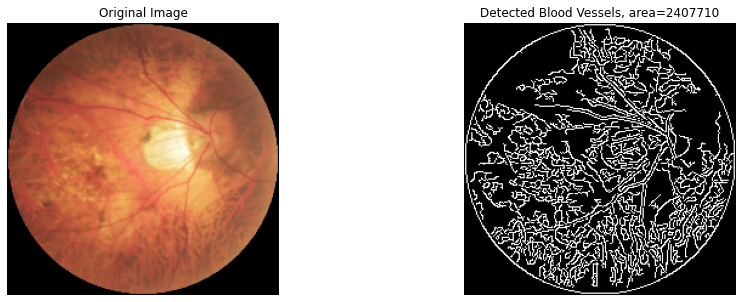

normal_236_right.jpg


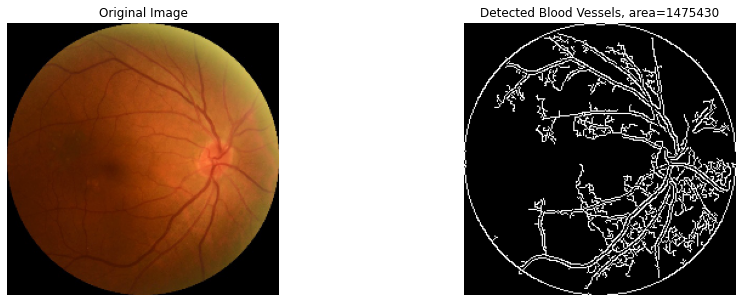

cataract_112_right.jpg


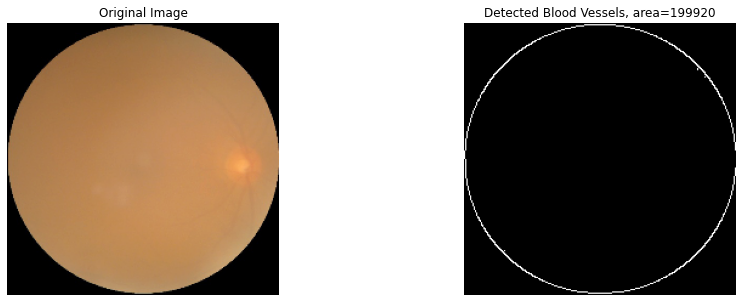

In [272]:
for file in os.listdir('subset'):
    print(file)
    visualize_vessels_path('subset/'+file)